## Dota 2: Win Probability Prediction

![Dota 2](https://i.imgur.com/XFr4HYE.jpg)

### Logistic Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb
import lightgbm as lgb

%matplotlib inline

#### 1. Считайте таблицу с признаками из файла features.csv. Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).

In [2]:
X_train = pd.read_csv('features.csv', index_col='match_id')
y_train = X_train['radiant_win'].apply(lambda x: int(x)).values
X_test = pd.read_csv('features_test.csv', index_col='match_id')

#### Описание признаков в таблице

- `match_id`: идентификатор матча в наборе данных
- `start_time`: время начала матча (unixtime)
- `lobby_type`: тип комнаты, в которой собираются игроки (расшифровка в `dictionaries/lobbies.csv`)
- Наборы признаков для каждого игрока (игроки команды Radiant — префикс `rN`, Dire — `dN`):
    - `r1_hero`: герой игрока (расшифровка в dictionaries/heroes.csv)
    - `r1_level`: максимальный достигнутый уровень героя (за первые 5 игровых минут)
    - `r1_xp`: максимальный полученный опыт
    - `r1_gold`: достигнутая ценность героя
    - `r1_lh`: число убитых юнитов
    - `r1_kills`: число убитых игроков
    - `r1_deaths`: число смертей героя
    - `r1_items`: число купленных предметов
- Признаки события "первая кровь" (first blood). Если событие "первая кровь" не успело произойти за первые 5 минут, то признаки принимают пропущенное значение
    - `first_blood_time`: игровое время первой крови
    - `first_blood_team`: команда, совершившая первую кровь (0 — Radiant, 1 — Dire)
    - `first_blood_player1`: игрок, причастный к событию
    - `first_blood_player2`: второй игрок, причастный к событию
- Признаки для каждой команды (префиксы `radiant_` и `dire_`)
    - `radiant_bottle_time`: время первого приобретения командой предмета "bottle"
    - `radiant_courier_time`: время приобретения предмета "courier" 
    - `radiant_flying_courier_time`: время приобретения предмета "flying_courier" 
    - `radiant_tpscroll_count`: число предметов "tpscroll" за первые 5 минут
    - `radiant_boots_count`: число предметов "boots"
    - `radiant_ward_observer_count`: число предметов "ward_observer"
    - `radiant_ward_sentry_count`: число предметов "ward_sentry"
    - `radiant_first_ward_time`: время установки командой первого "наблюдателя", т.е. предмета, который позволяет видеть часть игрового поля
- Итог матча (данные поля отсутствуют в тестовой выборке, поскольку содержат информацию, выходящую за пределы первых 5 минут матча)
    - `duration`: длительность
    - `radiant_win`: 1, если победила команда Radiant, 0 — иначе
    - Состояние башен и барраков к концу матча (см. описание полей набора данных)
        - `tower_status_radiant`
        - `tower_status_dire`
        - `barracks_status_radiant`
        - `barracks_status_dire`

Remove target variable and 6 features that are not about first five minutes from train dataset

In [3]:
drop_columns = ['radiant_win', 'duration', 'tower_status_radiant',
           'tower_status_dire', 'barracks_status_radiant','barracks_status_dire']

X_train.drop(drop_columns, axis=1, inplace=True)

In [4]:
X_train

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114402,1450265551,1,47,4,1706,1198,17,0,1,8,...,0,-29.0,180.0,-76.0,180.0,3,4,3,0,-24.0
114403,1450277704,0,43,4,1793,1416,17,0,1,5,...,0,-5.0,NaN,-82.0,NaN,4,3,2,0,-17.0
114404,1450291848,1,98,4,1399,540,1,0,0,5,...,2,-32.0,249.0,-70.0,NaN,1,1,3,1,-15.0


#### 2. Проверьте выборку на наличие пропусков. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.

Признаки с пропущенными значениями

In [5]:
X_train.columns[X_train.isnull().any()]

Index(['first_blood_time', 'first_blood_team', 'first_blood_player1',
       'first_blood_player2', 'radiant_bottle_time', 'radiant_courier_time',
       'radiant_flying_courier_time', 'radiant_first_ward_time',
       'dire_bottle_time', 'dire_courier_time', 'dire_flying_courier_time',
       'dire_first_ward_time'],
      dtype='object')

Количество пропусков в данных по каждому признаку

In [6]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_res = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        return mis_val_table_res[
            mis_val_table_res.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

missing_values_table(X_train)

,Missing Values,% of Total Values
first_blood_player2,43987,45.2
radiant_flying_courier_time,27479,28.3
dire_flying_courier_time,26098,26.8
first_blood_time,19553,20.1
first_blood_team,19553,20.1
first_blood_player1,19553,20.1
dire_bottle_time,16143,16.6
radiant_bottle_time,15691,16.1
radiant_first_ward_time,1836,1.9
dire_first_ward_time,1826,1.9


Банальные пропуски (отсутствие значений) в данных по играм за первые 5 мин могут быть обоснованы, например, тем что:

- не было совершено первых убийств за 5 мин игры
- игроки не покупали конкретный внутриигровой предмет, например, бутылку или варды
- и т.п.

#### 3. Замените пропуски на нули с помощью функции fillna(). На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.

In [7]:
X_train_null = X_train.fillna(value=0.0)
X_test_null = X_test.fillna(value=0.0)

X_train_mean = X_train.apply(lambda x: x.fillna(x.mean()), axis=0)
X_test_mean = X_test.apply(lambda x: x.fillna(x.mean()), axis=0)

X_train_large = X_train.fillna(value=9999999.0)
X_test_large = X_test.fillna(value=9999999.0)

#### 4. Какой столбец содержит целевую переменную? Запишите его название.

Столбец `radiant_win` содержит целевую переменную.

In [8]:
y_train

array([1, 1, 0, ..., 0, 0, 1])

#### 5. Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

In [9]:
%%time

kfold = KFold(n_splits=5, shuffle=True, random_state=41)

clf = GradientBoostingClassifier(n_estimators=30, random_state=41)

cv_score_null = np.mean(cross_val_score(clf, X_train_null, y_train, cv=kfold, scoring='roc_auc'))
cv_score_mean = np.mean(cross_val_score(clf, X_train_mean, y_train, cv=kfold, scoring='roc_auc'))
cv_score_large = np.mean(cross_val_score(clf, X_train_large, y_train, cv=kfold, scoring='roc_auc'))

print(f'CV ROC-AUC scores - null: {cv_score_null}, mean: {cv_score_mean}, large: {cv_score_large}')

CV ROC-AUC scores - null: 0.6893728084471435, mean: 0.6886831695564691, large: 0.6903659019589643
CPU times: user 7min 50s, sys: 702 ms, total: 7min 51s
Wall time: 7min 53s


Использование большого значения для заполнения пропусков в данном датасете улучшает метрику для градиентного бустинга, а заполнение средним - наиболее худший вариант

In [10]:
%%time

cv_scores = []

estimators = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for n in estimators:
    
    clf = GradientBoostingClassifier(n_estimators=n, random_state=41)
    cv_score = np.mean(cross_val_score(clf, X_train_large, y_train, cv=kfold, scoring='roc_auc'))
    cv_scores.append(cv_score)

CPU times: user 43min 13s, sys: 2.46 s, total: 43min 15s
Wall time: 43min 20s


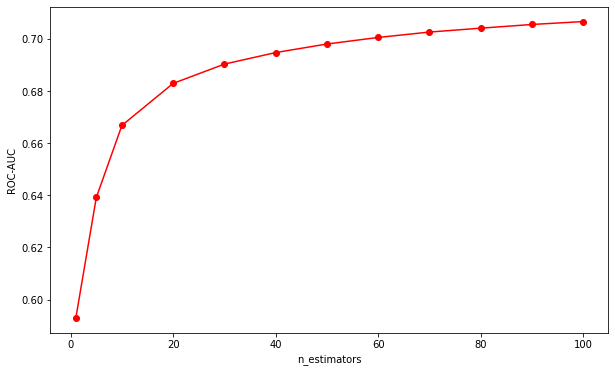

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(estimators, cv_scores, marker='o', color='r')
plt.xlabel('n_estimators')
plt.ylabel('ROC-AUC')
plt.show()

In [17]:
%%time

gr_boost = GradientBoostingClassifier(n_estimators=100, random_state=41)
gr_boost.fit(X_train_large, y_train)

y_pred = gr_boost.predict_proba(X_test_large)[:, 1]

CPU times: user 2min 5s, sys: 220 ms, total: 2min 5s
Wall time: 2min 5s


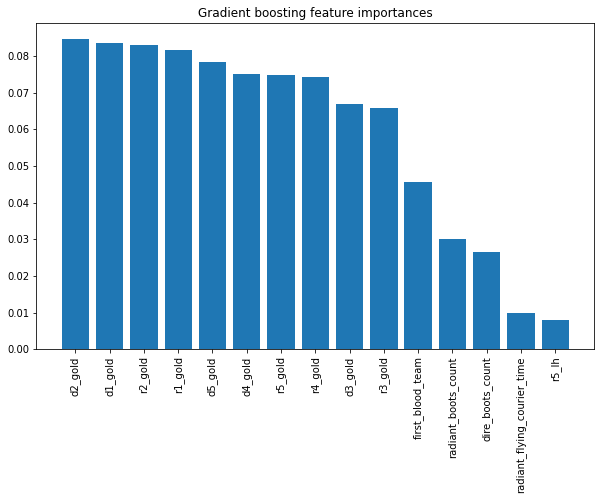

In [20]:
feat_importances = gr_boost.feature_importances_
indices = np.argsort(feat_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Gradient boosting feature importances")
plt.bar(range(15), feat_importances[indices[:15]], align='center')
plt.xticks(range(15), np.array(X_train_large.columns)[indices[:15]], rotation=90)
plt.show()

**Public score:** ROC-AUC = 0.71050

In [24]:
submission = pd.DataFrame()

submission['match_id'] = X_test_large.index
submission['radiant_win'] = y_pred

submission.to_csv('submission_gb.csv', index=None)

submission.head()

,match_id,radiant_win
0,6,0.508509
1,7,0.706565
2,10,0.425218
3,13,0.816004
4,16,0.219285


### Отчет:

- **Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?**

  Признаки: `first_blood_time`, `first_blood_team`, `first_blood_player1`, `first_blood_player2`,      `radiant_bottle_time`, `radiant_courier_time`, `radiant_flying_courier_time`, `radiant_first_ward_time`,
`dire_bottle_time`, `dire_courier_time`, `dire_flying_courier_time`, `dire_first_ward_time` имеют пропуски среди своих значений. 

  Банальные пропуски (отсутствие значений) в данных по играм за первые 5 мин могут быть обоснованы, например, тем что:

    - не было совершено первых убийств за 5 мин игры
    - игроки не покупали конкретный внутриигровой предмет, например, бутылку или варды
    - и т.п.

- **Как называется столбец, содержащий целевую переменную?**

  Столбец `radiant_win` содержит целевую переменную.
  
  
- **Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Инструкцию по измерению времени можно найти ниже по тексту. Какое качество при этом получилось? Напомним, что в данном задании мы используем метрику качества AUC-ROC.**

  Кросс-валидация для градиентного бустинга с 30 деревьями проводилась 2.5 мин, метрика ROC-AUC на кросс-валидации ~ 0.69


- **Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?**

  В данном случае имеет смысл использовать больше 30 деревьев, например 100, где качества на кросс-валидации увеличивается примерно на 3%. Но следует учитывать, что рост количества деревьев в градиентном бустинге может приводить к переобучению.

  Для ускорения обучения градиентного бустинга можно:
  
  - Используйте для обучения и кросс-валидации не всю выборку, а некоторое ее подмножество — например, половину объектов.
  - Упростить модель — изменить параметры, например, уменьшить глубину деревьев в градиентом бустинге (max_depth).

